In [19]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import sys
import os

# Get the parent folder path
parent_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Append the parent folder path to the system path
sys.path.append(parent_folder)

from inxss import SpectrumDataset, SpecNeuralRepr, PsiMask, linspace_2D_equidistant
from torch.utils.data import DataLoader


import config_matplotlib
config_matplotlib.config_matplotlib()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

registered cmap: seaborn_cubehelix



In [3]:
spec_dataset = SpectrumDataset(
    '/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/summarized_AFM_data_2023Sep13.pt',
    num_wq=50
    )

train_idx, val_test_idx = train_test_split(np.arange(len(spec_dataset)), test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=42)

train_loader = DataLoader([spec_dataset[i] for i in train_idx], batch_size=10, shuffle=True)
val_loader = DataLoader([spec_dataset[i] for i in val_idx], batch_size=10, shuffle=False)
test_loader = DataLoader([spec_dataset[i] for i in test_idx], batch_size=10, shuffle=False)

In [4]:
model = SpecNeuralRepr.load_from_checkpoint(
    '/pscratch/sd/z/zhantao/inxs_steering_production/models/version_14896845/checkpoints/epoch=7160-step=343728.ckpt'
    )

# model = SpecNeuralRepr.load_from_checkpoint(
#     '/pscratch/sd/z/zhantao/inxs_steering/lightning_logs/version_14896843/checkpoints/epoch=1165-step=55968.ckpt'
# )

In [51]:
from inxss import linspace_2D_equidistant, plot_points, get_Sqw_func

kpt_labels = ['$\mathrm{P}$', '$\mathrm{M}$', '$\mathrm{X}$', '$\mathrm{P}$', '$\Gamma$', '$\mathrm{X}$']

# kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
kpts = torch.from_numpy(linspace_2D_equidistant([[1/4,1/4], [1/2,1/2], [0,1/2], [1/4,1/4], [0,0], [0,1/2]], 100))
_, kpt_indices = linspace_2D_equidistant([[1/4,1/4], [1/2,1/2], [0,1/2], [1/4,1/4], [0,0], [0,1/2]], 100, return_indices=True)
wpts = spec_dataset.data_dict['w_grid']

In [12]:
x = torch.zeros(wpts.shape[0], kpts.shape[0], 5)

Text(0, 0.5, '$J_{p}$')

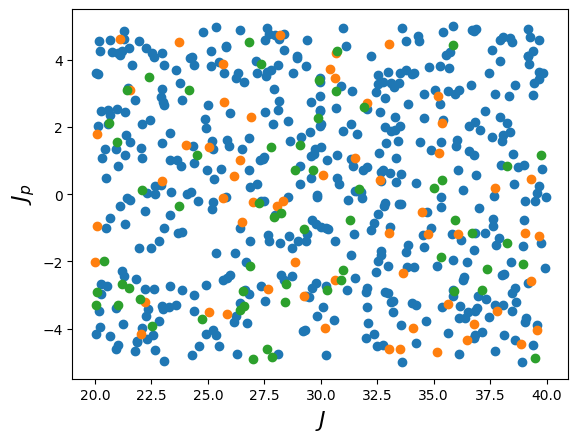

In [13]:
fig, ax = plt.subplots(1,1)
ax.scatter(spec_dataset.data_dict['params'][train_idx,0], spec_dataset.data_dict['params'][train_idx,1], label='train')
ax.scatter(spec_dataset.data_dict['params'][val_idx,0], spec_dataset.data_dict['params'][val_idx,1], label='val')
ax.scatter(spec_dataset.data_dict['params'][test_idx,0], spec_dataset.data_dict['params'][test_idx,1], label='test')
ax.set_xlabel('$J$', fontsize=16)
ax.set_ylabel('$J_{p}$', fontsize=16)


In [14]:
ax.legend()
fig.savefig('model_performance/sample_split.svg', bbox_inches='tight')

In [87]:
S_pred_list = []
S_true_list = []
params_list = []

for idx_plot in [1, 10, 20, 35, 59]:
# idx_plot = 35
    params = spec_dataset.data_dict['params'][test_idx[idx_plot]]
    print(params)
    # params = torch.tensor([26.85607403, -2.12352489])
    x[...,:3] = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
    ], dim=2)
    x[...,3:] = params

    S_pred = model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy()
    from scipy.interpolate import RegularGridInterpolator
    S_true_func = RegularGridInterpolator(
        (np.linspace(0, 0.5, 101), np.linspace(0, 0.5, 101), wpts.numpy()), 
        spec_dataset.data_dict['S'][test_idx[idx_plot]].reshape(-1, 101, 101).permute(1,2,0).numpy(), fill_value=0, bounds_error=False)
    S_true = S_true_func(x.detach().numpy()[...,:3])
    # plt.imshow(S_true, origin='lower')

    S_pred_list.append(S_pred)
    S_true_list.append(S_true)
    params_list.append(params)

tensor([22.4046,  3.4776], dtype=torch.float64)
tensor([26.8561, -2.1235], dtype=torch.float64)
tensor([35.9548, -0.7575], dtype=torch.float64)
tensor([39.7592,  1.1553], dtype=torch.float64)
tensor([27.6199, -4.6073], dtype=torch.float64)


In [88]:
import seaborn as sns
cmap = sns.color_palette("rocket", as_cmap=True)

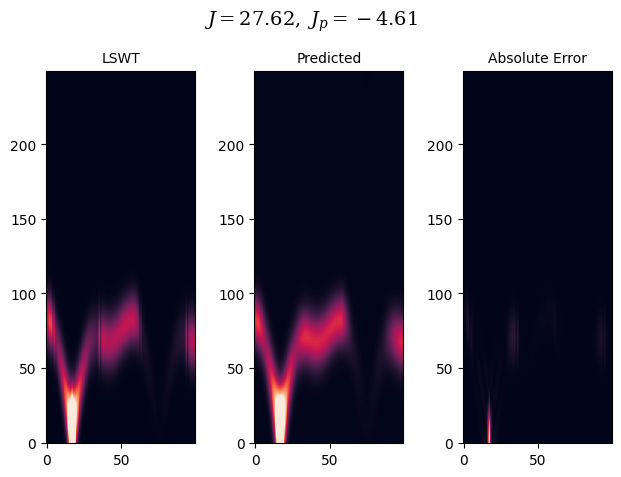

In [89]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(S_true_list[0], origin='lower', cmap=cmap, 
             vmax=S_true_list[0].mean() + 5*S_true_list[0].std())
ax[0].set_title('LSWT')
ax[1].imshow(S_pred_list[0], origin='lower', cmap=cmap,
             vmax=S_pred_list[0].mean() + 5*S_pred_list[0].std())
ax[1].set_title('Predicted')
ax[2].imshow(np.abs(S_pred_list[0]-S_true_list[0]), origin='lower', cmap=cmap)
ax[2].set_title('Absolute Error')


fig.suptitle(rf'$J={params[0]:.2f}, \ J_{{p}}={params[1]:.2f}$')
fig.tight_layout()
# fig.savefig(f"figures/model_performance/test_idx_{idx_plot}.svg", bbox_inches='tight')

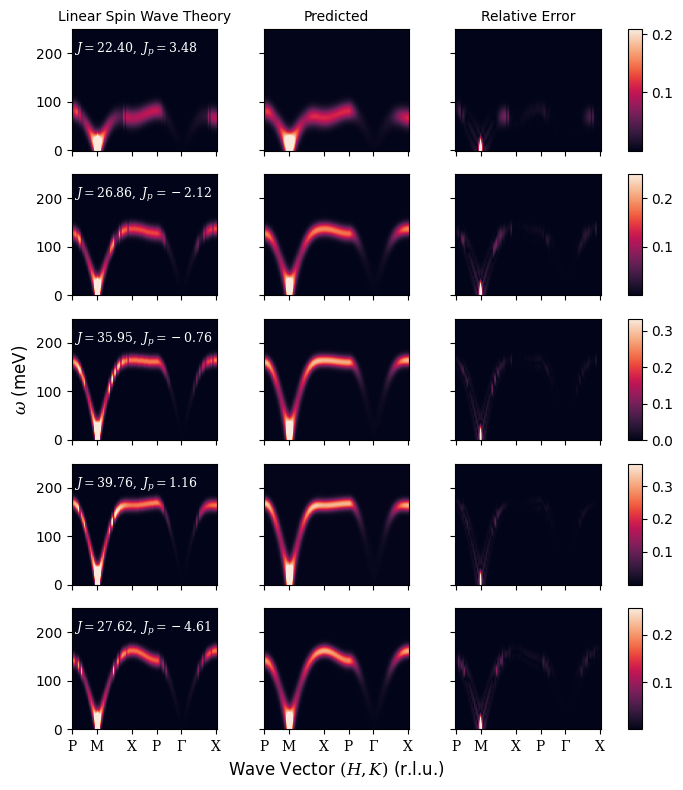

In [94]:
   

fig = plt.figure(figsize=(7,8))

gs = fig.add_gridspec(5, 4, width_ratios=[1,1,1,0.075])

for i in range(5):
    ax = fig.add_subplot(gs[i,0])
    ax.imshow(S_true_list[i], origin='lower', cmap=cmap, 
                vmax=S_true_list[0].mean() + 5*S_true_list[0].std())
    ax.set_aspect(1/3)
    
    if i == 0:
        ax.set_title('Linear Spin Wave Theory')
    if i == 4:
        ax.set_xticks(kpt_indices)
        ax.set_xticklabels(kpt_labels)
    else:
        ax.set_xticks(kpt_indices)
        ax.set_xticklabels([])
    
    if i == 2:
        ax.set_ylabel('$\omega$ (meV)')
    ax.text(1, 200, rf'$J={params_list[i][0]:.2f}, \ J_{{p}}={params_list[i][1]:.2f}$', 
            fontsize=9, color='w')
    
    
    ax = fig.add_subplot(gs[i,1])
    ax.imshow(S_pred_list[i], origin='lower', cmap=cmap,
                vmax=S_pred_list[0].mean() + 5*S_pred_list[0].std())
    ax.set_aspect(1/3)
    if i == 0:
        ax.set_title('Predicted')
    if i == 4:
        ax.set_xticks(kpt_indices)
        ax.set_xticklabels(kpt_labels)
        ax.set_xlabel('Wave Vector $(H,K)$ (r.l.u.)')
    else:
        ax.set_xticks(kpt_indices)
        ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    
    ax = fig.add_subplot(gs[i,2])
    im = ax.imshow(np.abs(S_pred_list[i]-S_true_list[i])/S_true_list[i].max(), 
                   origin='lower', cmap=cmap, vmax=S_true_list[i].max())
    ax.set_aspect(1/3)
    if i == 0:
        ax.set_title('Relative Error')
    if i == 4:
        ax.set_xticks(kpt_indices)
        ax.set_xticklabels(kpt_labels)
    else:
        ax.set_xticks(kpt_indices)
        ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    
    # frac_pos = ax.get_position(True)
    # print(frac_pos)

    # # Add colorbar
    # cbar_ax = fig.add_axes([
    #     frac_pos.x1+0.1, frac_pos.y0+0, 
    #     0.015, frac_pos.y1-frac_pos.y0])
    fig.colorbar(im, cax=fig.add_subplot(gs[i,3]))
    

# fig.text(0.5, -0.0125, 'Wave Vector $(H,K)$ (r.l.u.)', ha='center', fontsize=12)

# fig.suptitle(rf'$J={params[0]:.2f}, \ J_{{p}}={params[1]:.2f}$')
fig.tight_layout()
fig.savefig(f"figures/model_performance/model_prediction_demos.pdf", bbox_inches='tight')

In [99]:
train_loss = np.loadtxt('data/models_version_14896845_train_loss.csv', skiprows=1, delimiter=',')[:,1:]
val_loss = np.loadtxt('data/models_version_14896845_val_loss.csv', skiprows=1, delimiter=',')[:,1:]

In [116]:
val_loss[:,1].argmin()

896

In [117]:
val_loss[896]

array([3.61295000e+05, 2.82990111e-08])

In [115]:
val_loss.shape

(1000, 2)

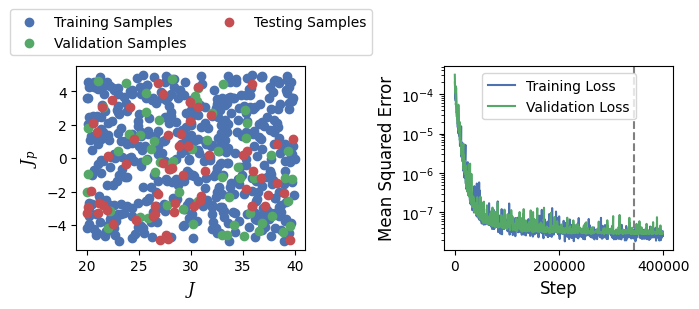

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

ax = axes[0]
ax.scatter(spec_dataset.data_dict['params'][train_idx,0], 
           spec_dataset.data_dict['params'][train_idx,1], label='Training Samples')
ax.scatter(spec_dataset.data_dict['params'][val_idx,0], 
           spec_dataset.data_dict['params'][val_idx,1], label='Validation Samples')
ax.scatter(spec_dataset.data_dict['params'][test_idx,0], 
           spec_dataset.data_dict['params'][test_idx,1], label='Testing Samples')
ax.set_xlabel('$J$')
ax.set_ylabel('$J_{p}$')

# Add legend to the top of the subplot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=2)



ax = axes[1]
ax.plot(train_loss[:,0], train_loss[:,1], label='Training Loss')
ax.plot(val_loss[:,0], val_loss[:,1], label='Validation Loss')
ax.set_yscale('log')
import matplotlib.pyplot as plt


ylim = ax.get_ylim()

ax.vlines(343728, 0, 1, color='gray', linestyle='--')
ax.set_ylim(ylim)

ax.legend(loc='upper center')

ax.set_xticks([0, 2e5, 4e5])
ax.set_xlabel('Step')
ax.set_ylabel('Mean Squared Error')

fig.tight_layout()
fig.savefig('figures/model_performance/model_training_info.pdf', bbox_inches='tight')